In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
from copy import deepcopy

print(os.listdir("../input"))

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

['sample_submission.csv', 'test.csv', 'data_description.txt', 'train.csv']


### Some credit here due to https://www.kaggle.com/apapiu/regularized-linear-models/notebook

## **Import and quick view of the data**

In [3]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

# test doesn't have 'SalePrice'
# Note that the 'Id' for train range 1-1460 and test range 1461-2919
print('Train Shape: {}, Train ID Range {} to {}'.format(train.shape,train.Id.min(), train.Id.max()))
print('Test Shape: {}, Test ID Range {} to {}'.format(test.shape,test.Id.min(), test.Id.max()))

Train Shape: (1460, 81), Train ID Range 1 to 1460
Test Shape: (1459, 80), Test ID Range 1461 to 2919


In [4]:
train.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [5]:
test.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal


In [6]:
# Let's combine the datasets for our data preprocessing
all_data = train.append(test,sort = False)
print(all_data.shape)
all_data.head()

(2919, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,...,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,...,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,...,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,...,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,...,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


### **Data type counts**

In [7]:
all_data.dtypes.groupby(all_data.dtypes).count()

int64      26
float64    12
object     43
dtype: int64

### **Pull numeric data types, list, and check/show count**

In [8]:
numerics = all_data.dtypes[all_data.dtypes != object].index.tolist()
print(numerics)
print(len(numerics))

['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']
38


- Looking for skewed data to log transform
- Will log-transform those with skew > .75

In [9]:
skew_calcs = all_data[numerics].skew().sort_values()
# Note that the skew filter below removes Id from the skewed feature list - we wouldn't have wanted to log-transform Id
skew_calcs = skew_calcs[skew_calcs > .75]
print(skew_calcs)
skew_feats = skew_calcs.index
# Also note that SalePrice will be log_transformed

TotRmsAbvGrd      0.758757
2ndFlrSF          0.862118
BsmtUnfSF         0.919824
TotalBsmtSF       1.162882
GrLivArea         1.270010
MSSubClass        1.376165
BsmtFinSF1        1.425722
1stFlrSF          1.470360
LotFrontage       1.503278
WoodDeckSF        1.843380
SalePrice         1.882876
OpenPorchSF       2.536417
MasVnrArea        2.602589
BsmtHalfBath      3.932018
ScreenPorch       3.948723
EnclosedPorch     4.005950
BsmtFinSF2        4.147456
KitchenAbvGr      4.304467
3SsnPorch        11.381914
LowQualFinSF     12.094977
LotArea          12.829025
PoolArea         16.907017
MiscVal          21.958480
dtype: float64


### **Quick and Dirty Visual of Distributions of skewed features before and after log transformation**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f38bc9c2198>,
      dtype=object)

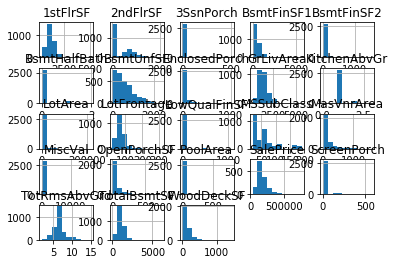

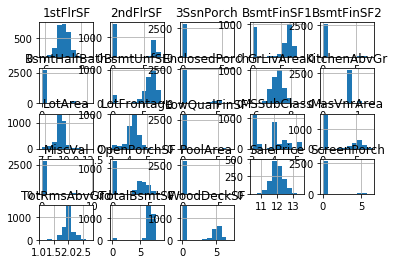

In [10]:
all_data[skew_feats].hist()
np.log1p(all_data[skew_feats]).hist()

## **Data pre-processing**

In [11]:
# Log-Transformation
all_data[skew_feats] = np.log1p(all_data[skew_feats])

#creating list of objects and View the unique strings in columns with object datatype
objects = train.dtypes[train.dtypes == object].index.tolist()
print(objects)
train[objects].apply(lambda x: set(x))

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


MSZoning                                 {RL, C (all), RM, RH, FV}
Street                                                {Pave, Grvl}
Alley                                            {nan, Pave, Grvl}
LotShape                                      {IR3, Reg, IR2, IR1}
LandContour                                   {Low, Lvl, Bnk, HLS}
Utilities                                         {AllPub, NoSeWa}
LotConfig                      {Inside, Corner, CulDSac, FR3, FR2}
LandSlope                                          {Mod, Gtl, Sev}
Neighborhood     {NAmes, StoneBr, SWISU, NridgHt, IDOTRR, Meado...
Condition1       {RRAn, Feedr, RRNe, PosA, PosN, Norm, Artery, ...
Condition2       {RRAn, Feedr, PosA, PosN, Norm, Artery, RRAe, ...
BldgType                     {Twnhs, 2fmCon, Duplex, 1Fam, TwnhsE}
HouseStyle       {1.5Fin, 2.5Fin, SFoyer, 2Story, SLvl, 1Story,...
RoofStyle               {Hip, Mansard, Gambrel, Shed, Flat, Gable}
RoofMatl         {ClyTile, CompShg, WdShngl, Roll, Metal, WdSh

### It looks like we can create dummy variables for all of the objects, since there aren't too many to handle...

In [12]:
# Create Dummy Variables
all_data = pd.concat([all_data,pd.get_dummies(all_data[objects])],axis = 1)
print(all_data.shape)

(2919, 333)


In [13]:
# Considered creating covariate dummies from those that occur most, but so many options, not digging this deep for now
pd.get_dummies(all_data[objects]).sum().sort_values(ascending = False).head(50)

Utilities_AllPub        2916
Street_Pave             2907
Condition2_Norm         2889
RoofMatl_CompShg        2876
Heating_GasA            2874
LandSlope_Gtl           2778
CentralAir_Y            2723
Functional_Typ          2717
Electrical_SBrkr        2671
GarageCond_TA           2654
PavedDrive_Y            2641
LandContour_Lvl         2622
BsmtCond_TA             2606
GarageQual_TA           2604
ExterCond_TA            2538
SaleType_WD             2525
Condition1_Norm         2511
BsmtFinType2_Unf        2493
BldgType_1Fam           2425
SaleCondition_Normal    2402
RoofStyle_Gable         2310
MSZoning_RL             2265
LotConfig_Inside        2133
BsmtExposure_No         1904
LotShape_Reg            1859
ExterQual_TA            1798
MasVnrType_None         1742
GarageType_Attchd       1723
HeatingQC_Ex            1493
KitchenQual_TA          1492
HouseStyle_1Story       1471
Foundation_PConc        1308
BsmtQual_TA             1283
Foundation_CBlock       1235
GarageFinish_U

In [14]:
# Remove original features now that dummies have been created
all_data = all_data.drop(objects,axis = 1)
print(all_data.shape)

(2919, 290)


### **Replacing Nulls with the mean of their respective columns**

In [15]:
all_data = all_data.fillna(all_data.mean())
# could also create dummy variable for nulls
all_data.head(3)

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,MSZoning_C (all),MSZoning_FV,...,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,MiscFeature_Gar2,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,4.110874,4.189655,9.042040,7,5,2003,2003,5.283204,6.561031,0.0,5.017280,6.753438,6.753438,6.751101,0.0,7.444833,1.0,0.000000,2,1,3,0.693147,2.197225,0,2003.0,2.0,548.0,0.000000,4.127134,0.0,0.0,0.0,0.0,0.0,2,2008,12.247699,0,0,...,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,2,3.044522,4.394449,9.169623,6,8,1976,1976,0.000000,6.886532,0.0,5.652489,7.141245,7.141245,0.000000,0.0,7.141245,0.0,0.693147,2,0,3,0.693147,1.945910,1,1976.0,2.0,460.0,5.700444,0.000000,0.0,0.0,0.0,0.0,0.0,5,2007,12.109016,0,0,...,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,3,4.110874,4.234107,9.328212,7,5,2001,2002,5.093750,6.188264,0.0,6.075346,6.825460,6.825460,6.765039,0.0,7.488294,1.0,0.000000,2,1,3,0.693147,1.945910,1,2001.0,2.0,608.0,0.000000,3.761200,0.0,0.0,0.0,0.0,0.0,9,2008,12.317171,0,0,...,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


### **Create Train and Test**

In [16]:
train_data = all_data[:1460]
# drop SalePrice from test_data, was created during fillna()
test_data = all_data[1460:].drop('SalePrice',axis = 1)

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
X = train_data.drop(['SalePrice'],axis = 1)
print(X.shape)
y = train_data['SalePrice']
print(y.shape)

(1460, 289)
(1460,)


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [20]:
def get_mse(model,alpha):
    run_model = model(alpha = alpha)
    run_model.fit(X_train,y_train)
    return mean_squared_error(y_pred=run_model.predict(X_test),y_true=y_test)

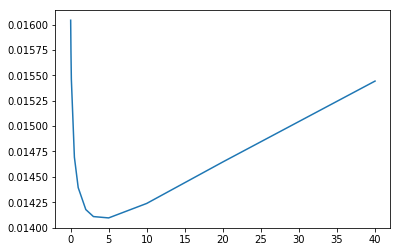

In [21]:
alphas = [.01,.05,0.1,0.5,1,2,3,5,10,20,40]
ridge_mses = [get_mse(Ridge,x) for x in alphas]
plt.plot(alphas,ridge_mses)

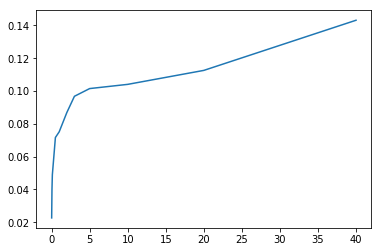

In [22]:
lasso_mses = [get_mse(Lasso,x) for x in alphas]
plt.plot(alphas,lasso_mses)

In [23]:
# alpha = 5 looks best
pd.DataFrame({'alpha':alphas, 'MSE':ridge_mses}).sort_values('MSE',ascending = True)

,alpha,MSE
7,5.00,0.014096
6,3.00,0.014109
5,2.00,0.014178
8,10.00,0.014239
4,1.00,0.014394
9,20.00,0.014647
3,0.50,0.014694
10,40.00,0.015443
2,0.10,0.015462
1,0.05,0.015726


In [24]:
ridge_model = Ridge(alpha = 5)
ridge_model.fit(X,y)
coefs = ridge_model.coef_

In [25]:
labels_and_weights = pd.DataFrame({'field':X.columns,'weight':coefs})

<BarContainer object of 18 artists>

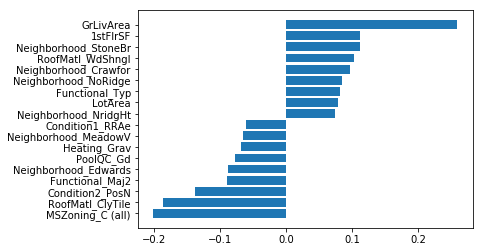

In [26]:
top_weight = labels_and_weights['weight'].quantile(.97)
bot_weight = labels_and_weights['weight'].quantile(.03)
heavy_weights = labels_and_weights[(labels_and_weights['weight']>top_weight) | (labels_and_weights['weight']<bot_weight)].sort_values('weight')
plt.barh(heavy_weights['field'],heavy_weights['weight'])

In [27]:
predictions = ridge_model.predict(test_data)

In [28]:
print(predictions.mean())
# inverse log-transform
preds = np.expm1(predictions)
print(preds.mean())

11.996242783437353
175828.34369247447


In [29]:
sub = pd.DataFrame()
sub['Id'] = test_data['Id']
sub['SalePrice'] = preds

In [30]:
sub.head()

,Id,SalePrice
0,1461,118397.464280
1,1462,152985.747495
2,1463,181904.263791
3,1464,197085.031222
4,1465,200223.256825


In [31]:
sub.to_csv('submission.csv',index=False)